In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector

import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor
from yellowbrick.regressor import ResidualsPlot, PredictionError

import shap
plt.rcParams['savefig.facecolor']='white'

/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [3]:
data_path = os.path.join(output_filepath, 'panel_data.parquet')
df_model = pd.read_parquet(data_path)

df_model = df_model[df_model.year.between(1995, 2016)]

centralities = ['hubs', 'authorities','pagerank', 'gfi', 'bridging', 'favor']
centralities = ['hubs', 'authorities', 'favor']
networks = ['financial', 'goods', 'human']

df_model = df_model[~df_model.country.isin(['ETH', 'BLR', 'ZWE', 'MDA', 'GUY', 'VNM', 'MAC', 'PSE', 'AGO', 'COD', 'TZA'])]

for c in [f'{n}_{c}' for c in centralities for n in networks]:
    df_model[c] = df_model[c].map(lambda x: np.log1p(x*1.e8))

#df_model = df_model[df_model.wkn_population>1.e6]

In [4]:
all_centralities = [f'{n}_{c}' for c in centralities for n in networks]
all_centralities.remove('goods_favor')
all_centralities.remove('financial_favor')

controls = ['log_GFCF', 'log_wkn_population', 'year', 'country']
x_labels = all_centralities +  controls
y_label = 'log_gdp'

In [5]:
# Split
X_train, X_test, y_train, y_test = train_test_split(df_model[x_labels], df_model[y_label], test_size=0.33, random_state=42, stratify=df_model[['country']] )

# Transform
# Impute numeric values with median 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median',add_indicator=True)),
    ('transformer', FunctionTransformer(None, validate=False))])

# Impute categorical features with 'missing' and one-hot-encode them
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value='missing',
                              add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine all transformers in a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=["float64", "int64"])),
        ('cat', categorical_transformer, make_column_selector(dtype_include=["object"])),])

regressor = Pipeline(steps=[ ('preprocessor', preprocessor),
                             ('GradientBoostingRegressor', GradientBoostingRegressor())])

model_pipe = TransformedTargetRegressor(regressor, func=None, inverse_func=None)

params = {'regressor__GradientBoostingRegressor__max_depth':[2,3,4],
          'regressor__GradientBoostingRegressor__learning_rate':[0.5,0.1,0.05, 0.01],
          'regressor__GradientBoostingRegressor__n_estimators':[int(n) for n in np.logspace(1,3.5,20)],
          'regressor__GradientBoostingRegressor__subsample':[0.8],
          'regressor__GradientBoostingRegressor__max_features':['auto']}
params = {'regressor__GradientBoostingRegressor__learning_rate': [0.1],
          'regressor__GradientBoostingRegressor__max_depth':[2],
          'regressor__GradientBoostingRegressor__max_features': ['auto'],
          'regressor__GradientBoostingRegressor__n_estimators': [3162],
          'regressor__GradientBoostingRegressor__subsample': [0.8]}
model = GridSearchCV(model_pipe, param_grid=params, cv=5, verbose=1, n_jobs=4)

model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   24.8s finished


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('num',
                                                                                                              Pipeline(steps=[('imputer',
                                                                                                                               SimpleImputer(add_indicator=True,
                                                                                                                                             strategy='median')),
                                                                                                                              ('transformer',
                                                                                                                               FunctionTransformer())]),
               

In [6]:
model.best_params_

{'regressor__GradientBoostingRegressor__learning_rate': 0.1,
 'regressor__GradientBoostingRegressor__max_depth': 2,
 'regressor__GradientBoostingRegressor__max_features': 'auto',
 'regressor__GradientBoostingRegressor__n_estimators': 3162,
 'regressor__GradientBoostingRegressor__subsample': 0.8}

In [7]:
model.score(X_test, y_test)

0.9937524907196612

<AxesSubplot:title={'center':'Residuals for GridSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

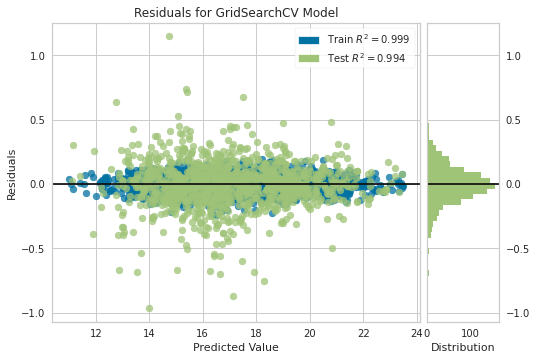

In [8]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'residuals_ml_model.png')
visualizer.show(outpath=save_to)

<AxesSubplot:title={'center':'Prediction Error for GridSearchCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

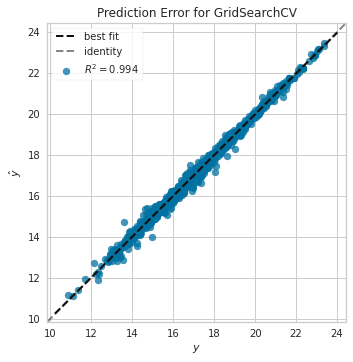

In [9]:
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'prediction_errors_ml_model.png')
visualizer.show(outpath=save_to)

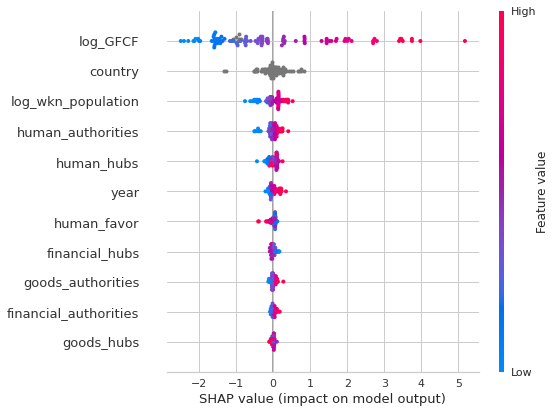

In [10]:
n_points = 100
X_set = X_test.sample(n_points)

X_set = shap.sample(X_test, n_points)

def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=X_test.columns)
    return model.best_estimator_.predict(data_asframe)

explainer = shap.KernelExplainer(model_predict, data=X_set.values, feature_names = x_labels, algorithm = 'auto')
shap_values = explainer.shap_values(X_set)

shap.summary_plot(shap_values, X_set, show=False)


save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'shap_values_levels.png')
plt.tight_layout()
plt.savefig(save_to)    
plt.show()

## Time series model

In [11]:
lagged_all_terms_list = ['delta_financial_' + c for c in centralities] + ['delta_human_' + c for c in centralities]
x_labels = ['lag_log_output', 'lag_log2_output', 'country', 'year'] + lagged_all_terms_list
x_labels = all_centralities +  controls + ['lag_log_output', 'lag_log2_output']
y_label = 'delta_log_output'

In [12]:
# Split
df_model_no_nan = df_model.dropna(subset=[y_label])
X_train, X_test, y_train, y_test = train_test_split(df_model_no_nan[x_labels], df_model_no_nan[y_label], test_size=0.33, random_state=42, stratify=df_model_no_nan[['country']] )

# Transform
# Impute numeric values with median 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median',add_indicator=True)),
    ('transformer', FunctionTransformer(None, validate=False))])

# Impute categorical features with 'missing' and one-hot-encode them
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value='missing',
                              add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine all transformers in a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=["float64", "int64"])),
        ('cat', categorical_transformer, make_column_selector(dtype_include=["object"])),])

regressor = Pipeline(steps=[ ('preprocessor', preprocessor),
                             ('GradientBoostingRegressor', GradientBoostingRegressor())])

model_pipe = TransformedTargetRegressor(regressor, func=None, inverse_func=None)

params = {'regressor__GradientBoostingRegressor__max_depth':[2,3,4],
          'regressor__GradientBoostingRegressor__learning_rate':[0.5,0.1,0.05,0.01],
          'regressor__GradientBoostingRegressor__n_estimators':[int(n) for n in np.logspace(1,3.5,20)],
          'regressor__GradientBoostingRegressor__subsample':[0.8],
          'regressor__GradientBoostingRegressor__max_features':['auto']}
model = GridSearchCV(model_pipe, param_grid=params, cv=5, verbose=1, n_jobs=4)

model.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 11.9min
[Parallel(n_jobs=4)]: Done 1200 out of 1200 | elapsed: 19.5min finished


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('num',
                                                                                                              Pipeline(steps=[('imputer',
                                                                                                                               SimpleImputer(add_indicator=True,
                                                                                                                                             strategy='median')),
                                                                                                                              ('transformer',
                                                                                                                               FunctionTransformer())]),
               

In [13]:
model.best_params_

{'regressor__GradientBoostingRegressor__learning_rate': 0.1,
 'regressor__GradientBoostingRegressor__max_depth': 4,
 'regressor__GradientBoostingRegressor__max_features': 'auto',
 'regressor__GradientBoostingRegressor__n_estimators': 45,
 'regressor__GradientBoostingRegressor__subsample': 0.8}

In [14]:
model.score(X_test, y_test)

0.3299861338416914

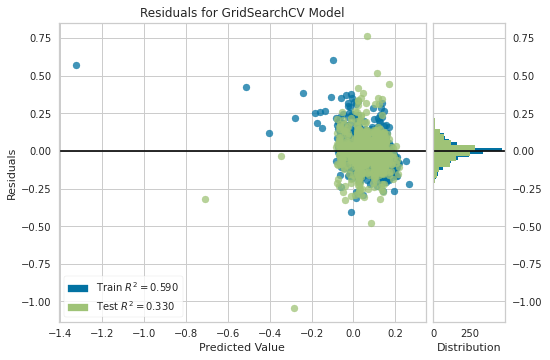

<AxesSubplot:title={'center':'Residuals for GridSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [15]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show() 

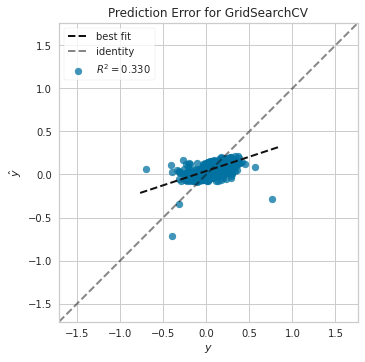

<AxesSubplot:title={'center':'Prediction Error for GridSearchCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [16]:
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show() 

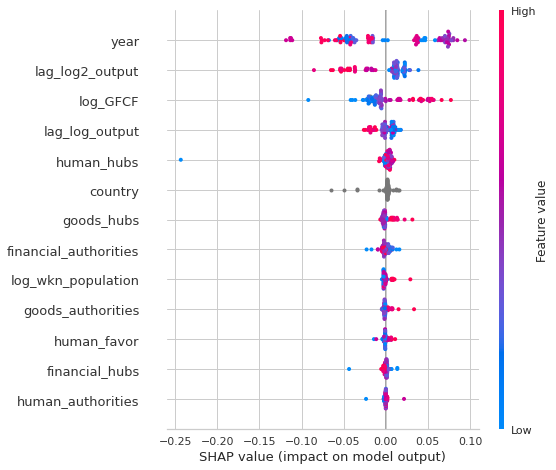

In [21]:
n_points = 100

X_set = shap.sample(X_test, n_points)

def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=X_test.columns)
    return model.best_estimator_.predict(data_asframe)

explainer = shap.KernelExplainer(model_predict, data=X_set.values, feature_names = x_labels, algorithm = 'auto')
shap_values = explainer.shap_values(X_set)

shap.summary_plot(shap_values, X_set, show=False)

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'shap_values_time_series.png')
plt.tight_layout()
plt.savefig(save_to)    
plt.show()

<AxesSubplot:xlabel='year', ylabel='delta_log_output'>

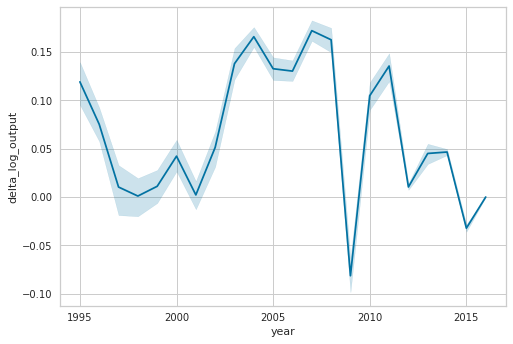

In [19]:
'''
Negative effect of time can be explained by a growth decline for the sample countries and time sample
'''
import seaborn as sns
sns.lineplot(data=df_model, x='year', y='delta_log_output')